![Banner](./img/AI_Special_Program_Banner.jpg)


# Evaluation and quality measures
---

In this section, we will deal with the evaluation of an ML algorithm. The correct evaluation of such a model is crucial for its successful productive use, but it is also a non-trivial problem. This chapter is based on chapter 6 of [Raschka's book](https://sebastianraschka.com/books/).

> A formal review of the content presented here can be found in chapters 5.2, 5.3 and 5.4 of the [Deep Learning Book](https://www.deeplearningbook.org/).

## Table of contents
---

- [Summarize common ML work steps with pipelines](#Summarize-common-ML-work-steps-with-pipelines)
   - [Reading in the data](#Reading-in-the-data)
   - [Create pipeline](#Create-pipeline)
- [Evaluation: Holdout method and cross-validation](#Evaluation:-Holdout-method-and-cross-validation)
   - [Holdout method](#Holdout-method)
   - [k-fold cross-validation](#k-fold-cross-validation)
- [Diagnosis and debugging of bias variance problems](#Diagnosis-and-debugging-of-bias-variance-problems)
- [Insert: Hyperparameter Tuning and Model Selection](#Insert:-Hyperparameter-tuning-and-model-selection)
- [Besides accuracy: important performance metrics and quality measures](#Besides-accuracy:-important-performance-metrics-and-quality-measures)
   - [Confusion matrix](#Confusion-matrix)
   - [Specificity and sensitivity](#Specificity-and-sensitivity)
   - [ROC-curve](#ROC-curve)
- [Learning outcomes](#Learning-outcomes)

## Summarize common ML work steps with `pipelines`
---

We have seen that similar steps often have to be applied when working with ML algorithms. These mainly concern the preparation of the data (*Data Preparation*), for example by scaling/normalization, dimensionality reduction, etc. With the `Pipeline` class of `scikit-learn` we can compactly summarize this process into a *pipeline*. This pipeline can also be easily transferred to new data sets.

### Reading in the data

Let's take another look at medical data as an example, namely the [Breast Cancer Wisconsin Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)). It contains 569 entries on benign and malignant tumors. The attributes contain information on the cell nuclei extracted from biopsy images of the breast.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

# in case the dataset is not available online:
# df = pd.read_csv('./data/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The first two columns contain a unique ID of the samples, as well as the label vector (M = malignant, B = benign). We extract the values as feature matrix `X` and label vector `y`:

In [4]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [5]:
le.transform(['M', 'B'])

array([1, 0])

### Create pipeline

Since the attributes of the dataset are different and therefore have different scales, we should scale them accordingly (at least if we want to apply a **logistic regression**, as we do here). We could also compress our data into a low-dimensional space using a [PCA](https://de.wikipedia.org/wiki/Hauptkomponentenanalyse). We can summarize these steps with a pipeline:

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X, y)
y_pred = pipe_lr.predict(X)
print('Accuracy: %.3f' % pipe_lr.score(X, y))

Accuracy: 0.956


The [make_pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) function of `scikit-learn` represents a concatenation of *transformers* (objects that implement *fit-transform*) followed by an *estimator* (*prediction model*). In this example, we use two transformers: `StandardScaler` and `PCA`, followed by a `LogisticRegression` as a prediction model. When using a pipeline, the `fit` and `transform` functions of the transformers are called in sequence and finally the prediction model is *fitted*. The entire pipeline thus serves as a *meta-prediction model* and implements all the prediction functions (e.g. *predict*, *predict_proba*, *score*, etc.) that we are used to from `scikit-learn`.

A major advantage of the pipeline is the possibility of **transferring to other data sets**. We will make use of this in the following evaluation.

## Evaluation: Holdout method and cross-validation
---

In application, an ML model is supposed to make predictions and/or provide estimates. The model is therefore inevitably confronted with data that it has not seen in the training phase. It is therefore not enough to determine the quality of our model on the training data, because we cannot make any statement about how well the model works with unknown data. We therefore want to assess the ability to **generalize**.

Also remember: ML models are naturally prone to **overfitting** (high *variance*) or **underfitting** (high *bias*). This overfitting or underfitting to the training data directly influences the generalization ability of a model. To find an acceptable *bias-variance* trade-off, we need to skillfully evaluate our model. The simplest and most popular method is certainly the **holdout method**:

### Holdout method

With the holdout method, we split the available data into training and test data (**split**). The training data is used for training and the test data is used to evaluate the generalization capability of the model. This can be implemented quite easily in `scikit-learn` with [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, 
                     test_size=0.20,
                     stratify = y,
                     random_state=42)

Here we set aside 20% of our data as test data. The parameter `stratify = y` is important here. This ensures that the distribution of the classes in both splits is identical (**stratified**). For example, we can check the distribution as follows:

In [8]:
from collections import Counter
Counter(y)

Counter({0: 357, 1: 212})

A naive model could take advantage of this uneven distribution and always predict the more frequent class. The resulting accuracy is also referred to as **null-accuracy**. In this case it is:

In [9]:
(y == 0).sum()/len(y)

0.6274165202108963

The accuracy of a model must therefore always be evaluated **in relation to the null-accuracy**!

With the help of the `Pipeline` we can now easily test our model in just a few lines of code:

In [10]:
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Accuracy: 0.947


However, splitting the data in this way poses a **problem**. Usually, we not only need to test different ML models, but also choose different values for the hyperparameters (called **Model Selection**). By doing so, we maximize the accuracy of the model on a specific split (test data). In this case, it is the user who provokes an *overfitting* of the model with respect to the test data. Thus, the generalization ability of the model cannot be properly evaluated.

To avoid this, a **division** of the data is often made: **training data**, **validation data** and **test data**. This results in the following procedure:
1. Training on the **training data**
2. Performance on the **validation data** is used to select models and hyperparameters (model selection)
3. Final assessment of the quality of the model on the **test data**

At best, the test data should only be used **once**. This makes intuitive sense: if you were to use the test data more often, you would have to start all over again. If you are dissatisfied with the performance of the model on the test data, the only option is to obtain new test data.

The repeated execution of step 2 is also referred to as **holdout cross-validation**:

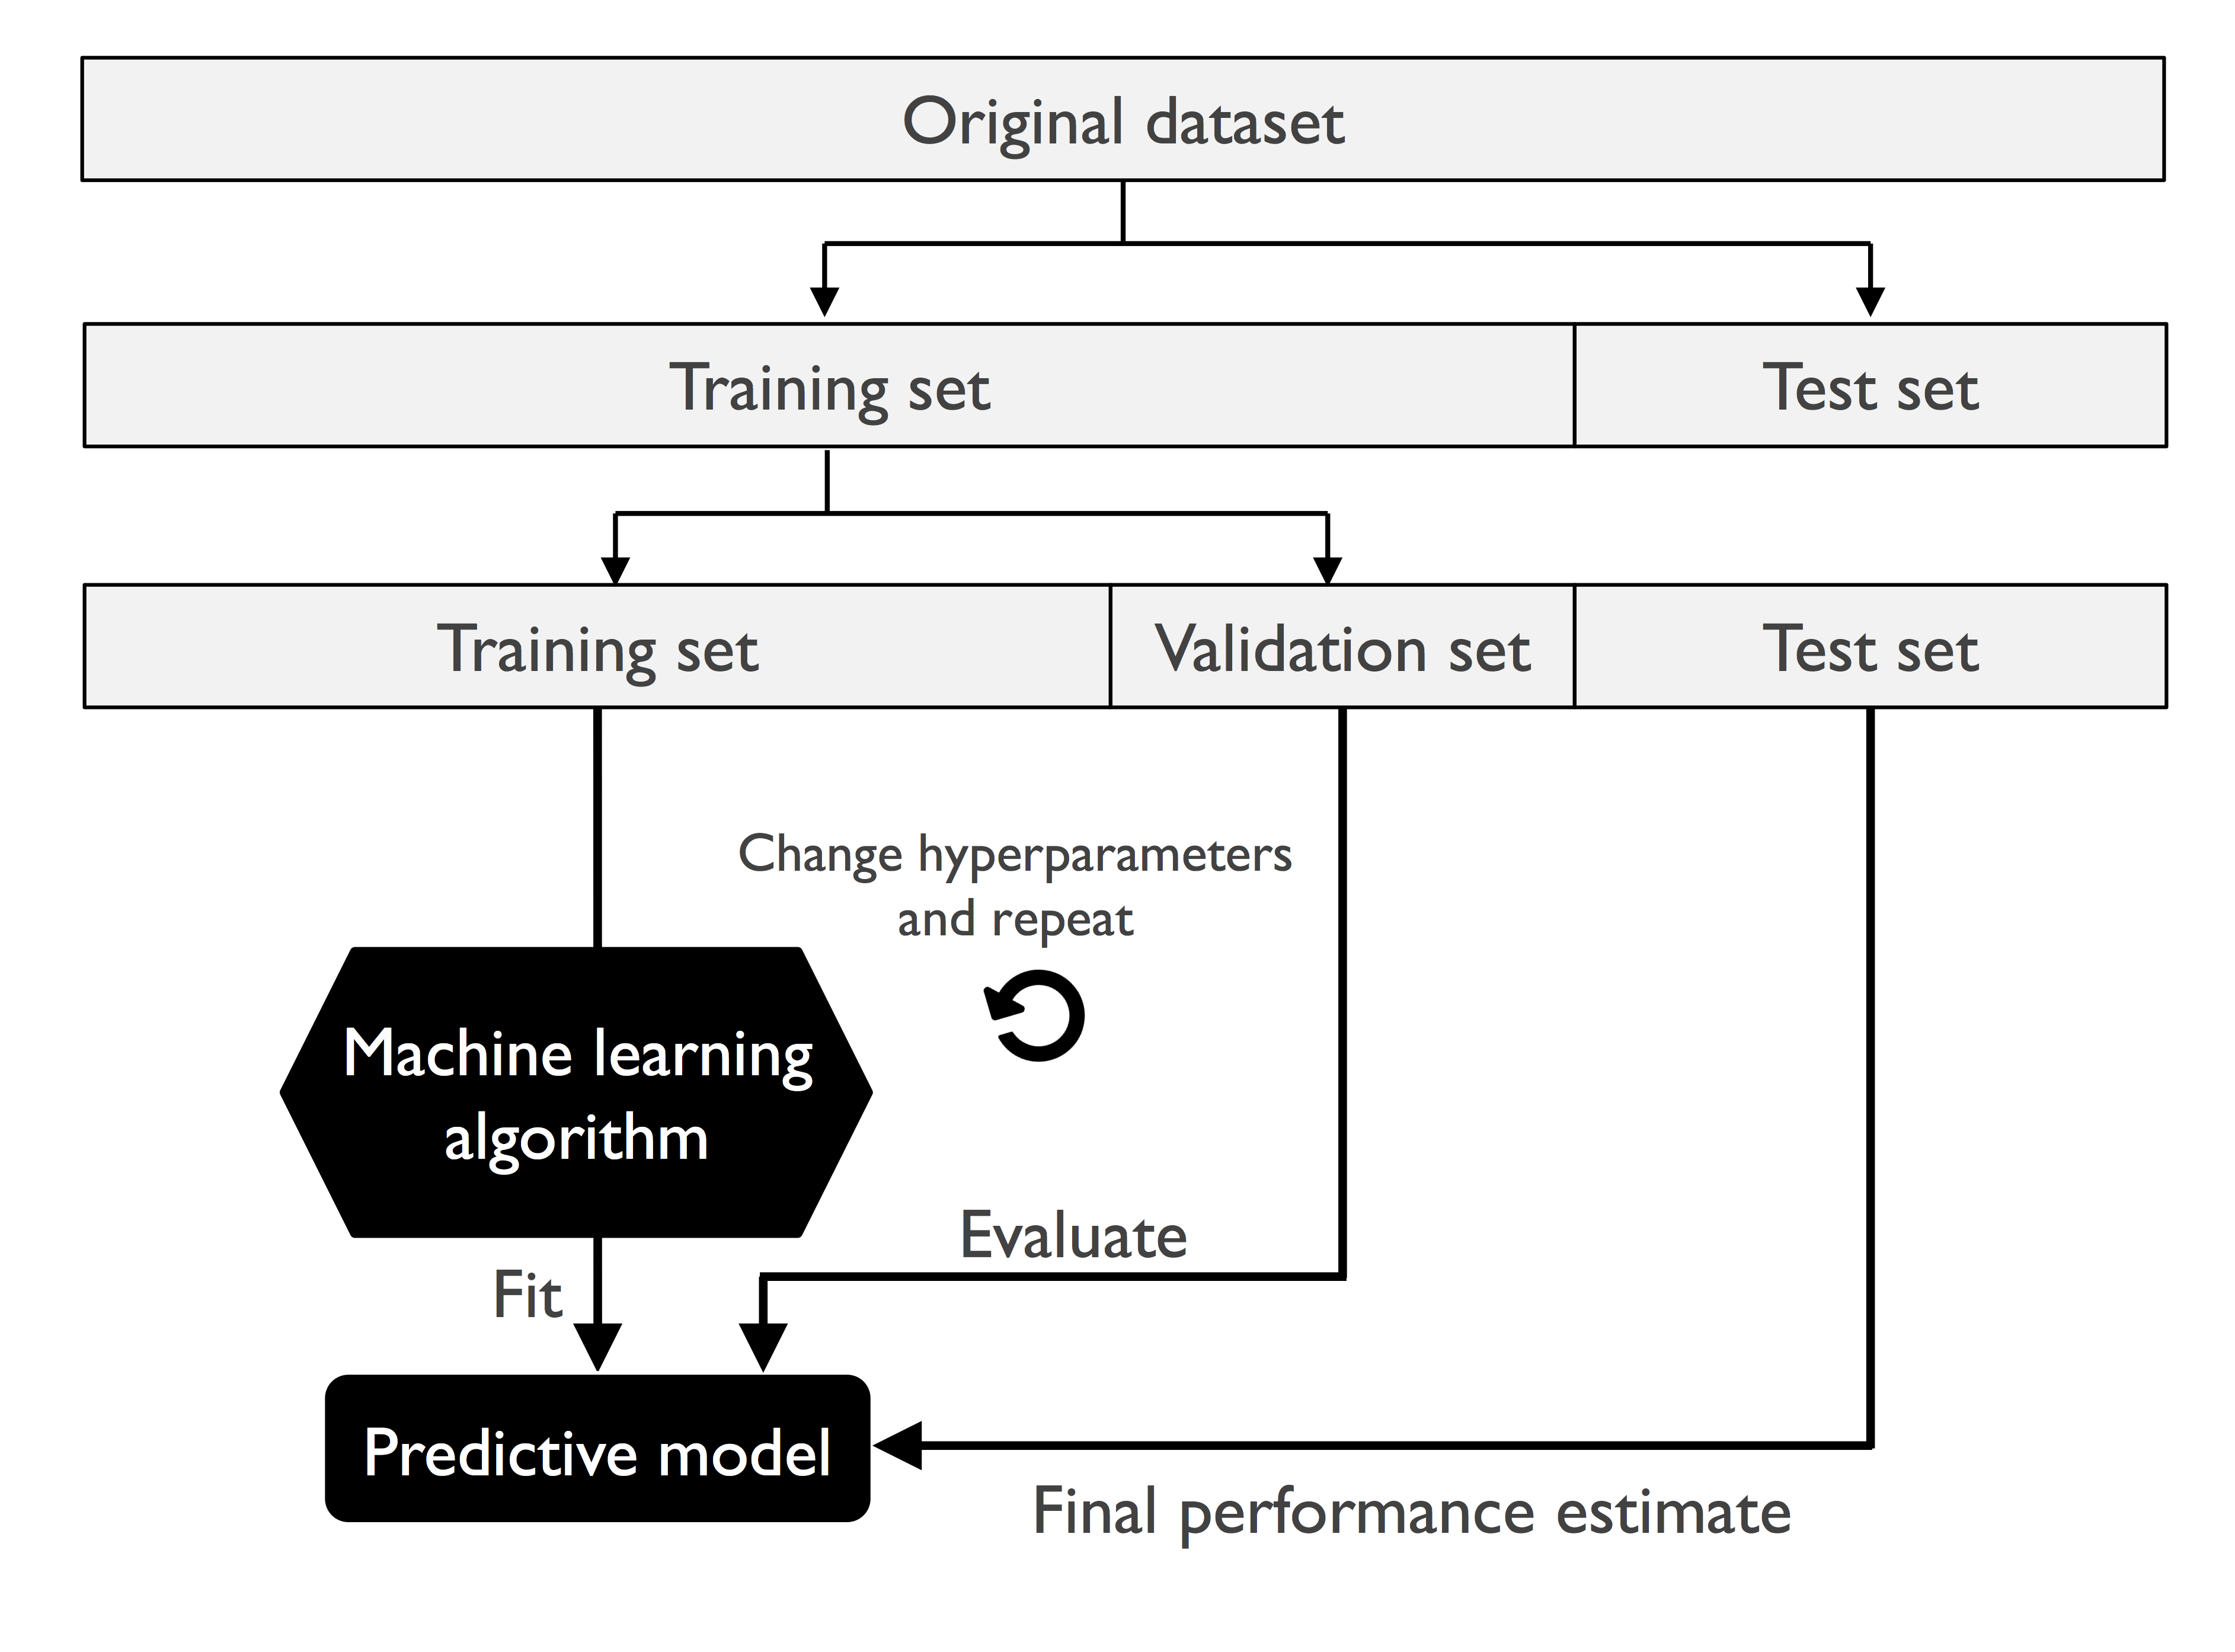

In [11]:
from IPython.display import Image
Image(filename='img/06_02.png', width=500)

[Image Source: Raschka](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb)

One disadvantage of this method is the dependence of performance on a specific split. Depending on the partitioning of the data, the model quality can easily be over- or underestimated. A more robust method is **k-fold cross-validation**.

### k-fold cross-validation

In **k-fold cross-validation**, we divide the training data into $k$ disjoint subsets, where $k-1$ subsets are used for training the model and one subset is used for evaluation. This process is repeated $k$ times so that we obtain $k$ estimates for the model performance. We then calculate the average performance of the model based on the different, independent test subsets. This type of evaluation is therefore less susceptible to variance in subsets of the training data (compared to the holdout method).

The following visualization illustrates the estimation of the performance $E$ with a 10-fold cross-validation:

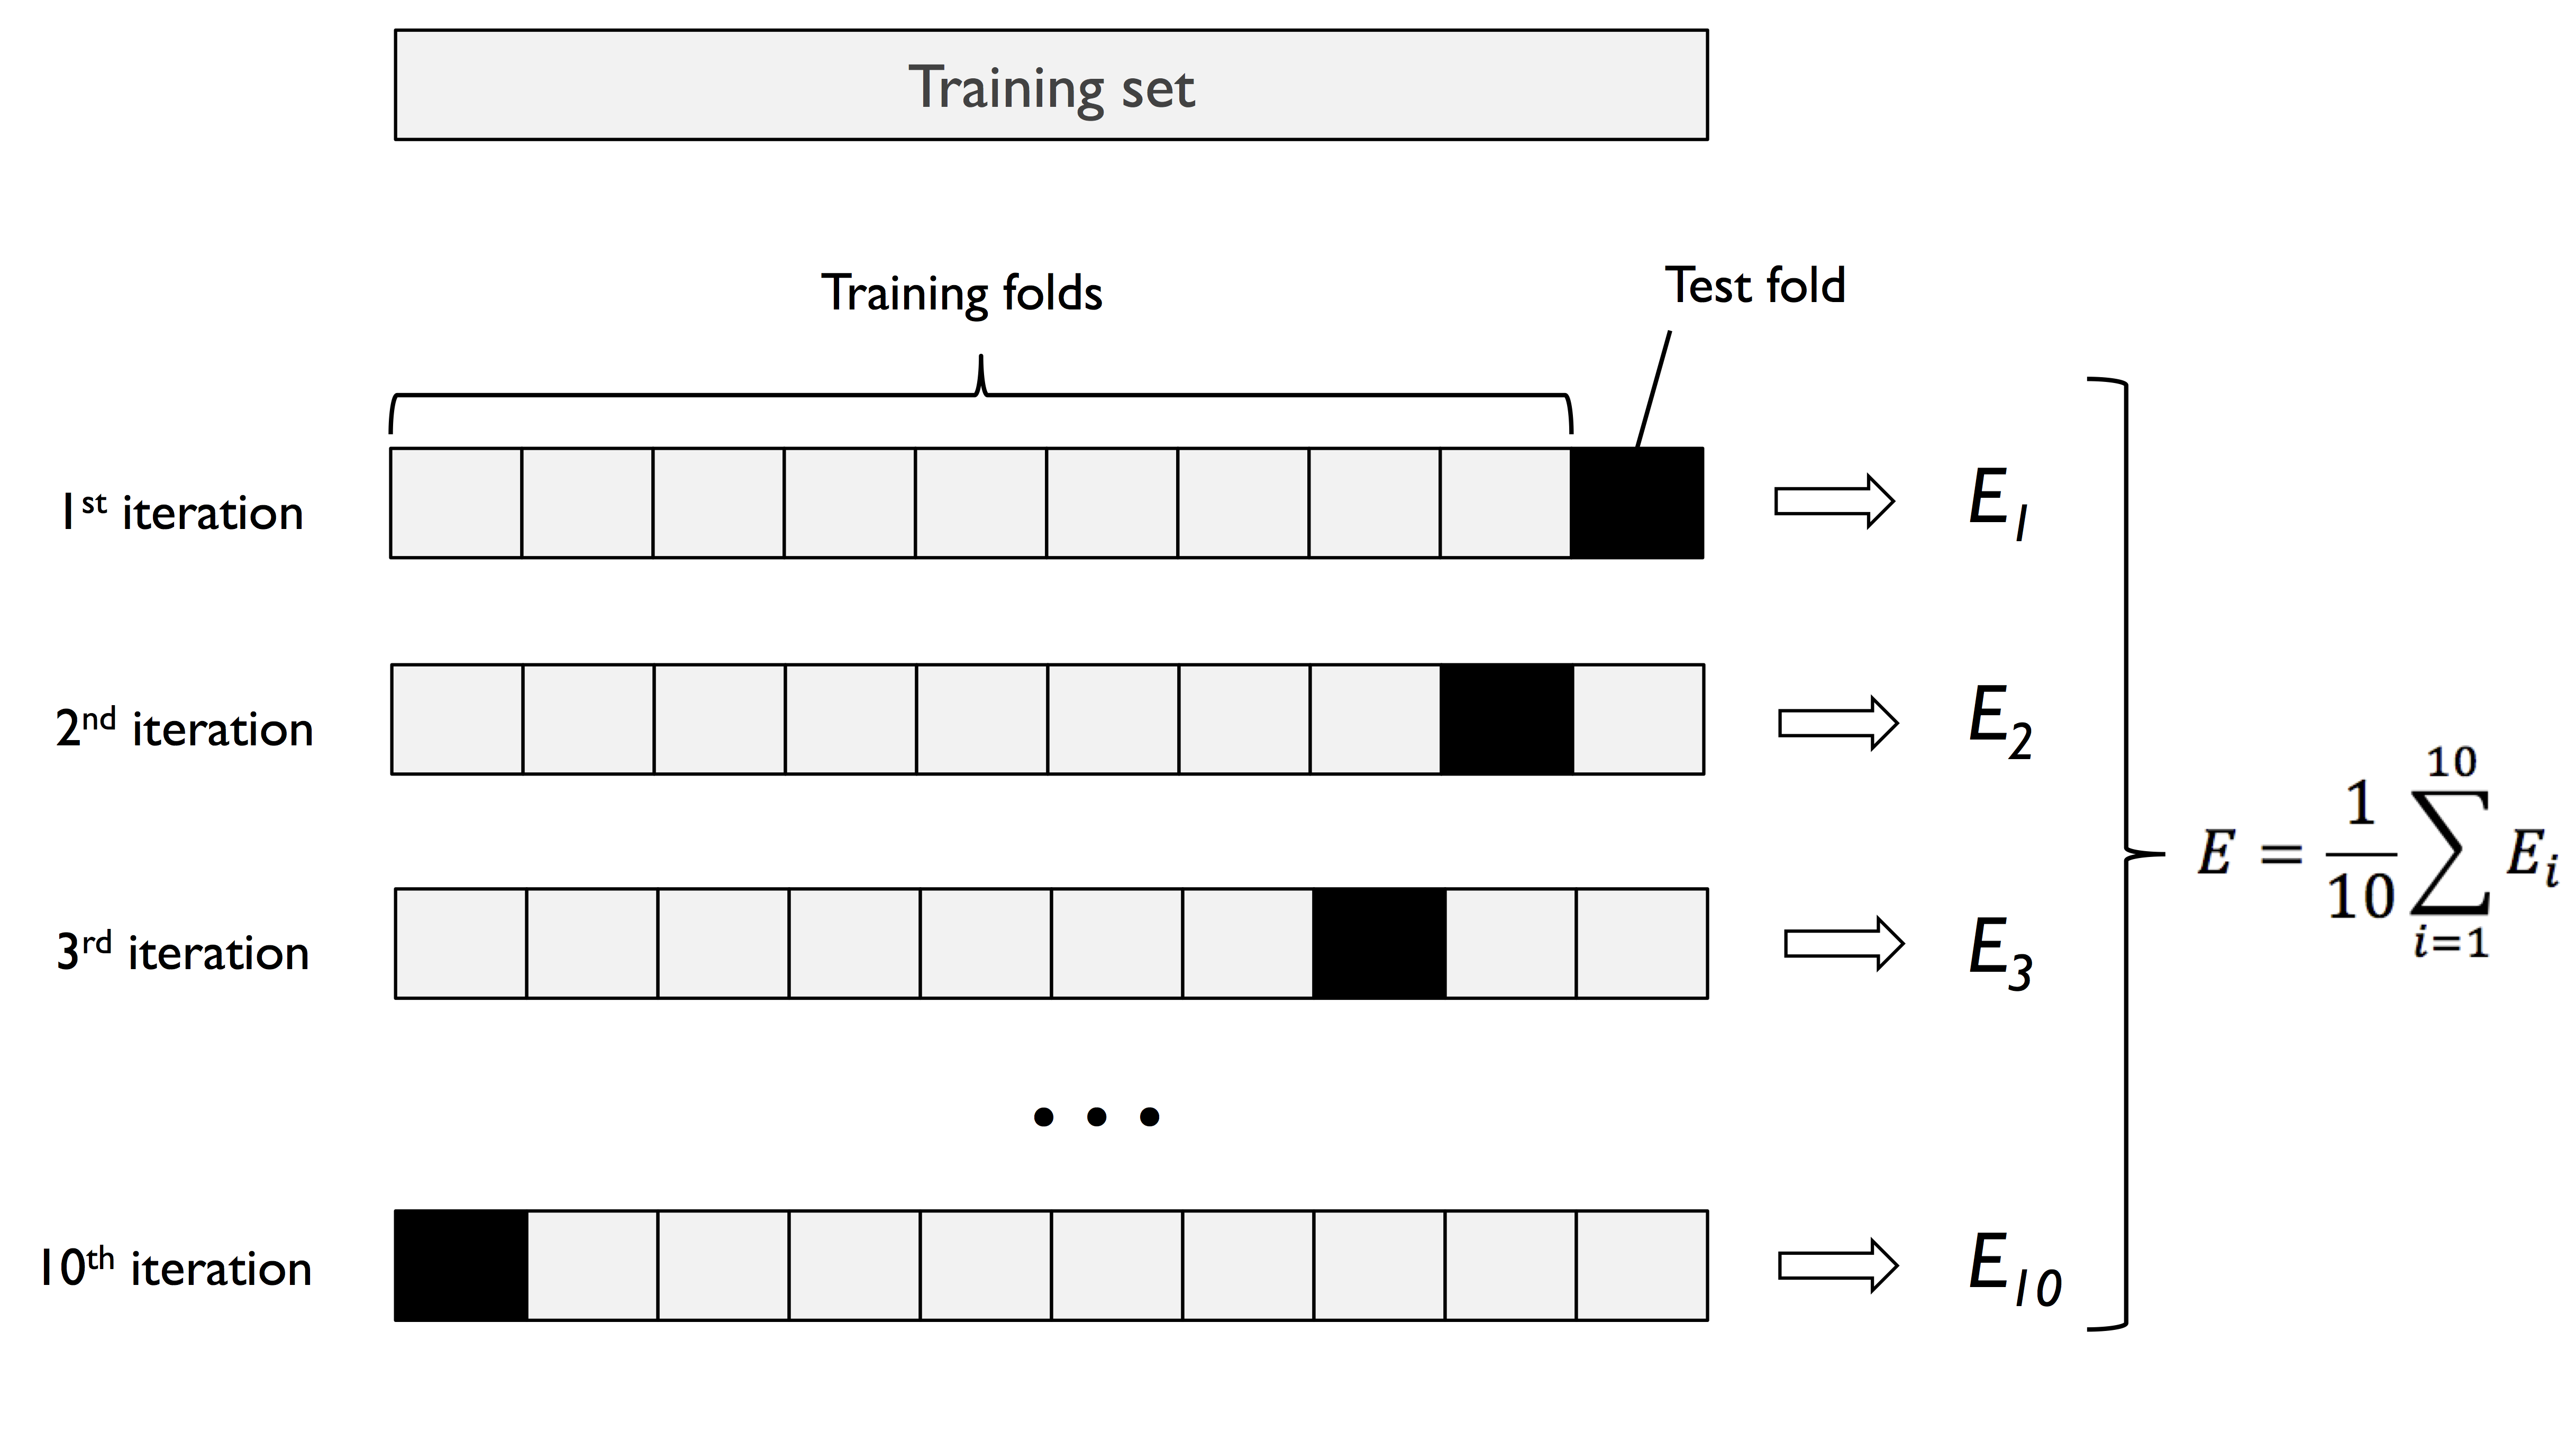

In [12]:
Image(filename='img/06_03.png', width=500)

[Image Source: Raschka](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb)

In practice, $k=10$ is often chosen, which seems to be a good value, at least from an empirical point of view (see [Ron Kohavi](https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf)). However, a *bias-variance trade-off* must also be taken into account when choosing $k$. For large $k$, a larger proportion of the data is used for training, which leads to a lower pessimistic bias (*bias*) in the estimation of generalization ability. However, large values of $k$ increase the runtime and lead to a larger variance as the training subsets are more similar. Further information on the choice of $k$ can also be found [here](https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/) and [here](https://stats.stackexchange.com/questions/27730/choice-of-k-in-k-fold-cross-validation).

An improvement over simple k-fold cross-validation is offered by **stratified** k-fold cross-validation. This method ensures that the distribution of the classes in the $k$ subsets is approximately identical. This reduces the variance of the estimate. This procedure should always be used for data sets in which the distribution of classes is unequal (*imbalanced classes*).

The implementation in `scikit-learn` uses the iterator `StratifiedKFold`, with the help of which we can iterate through the subsets by loop:

In [13]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Subset: %2d, class distribution: %s, accuracy: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Subset:  1, class distribution: [256 153], accuracy: 0.957
Subset:  2, class distribution: [256 153], accuracy: 0.913
Subset:  3, class distribution: [256 153], accuracy: 0.978
Subset:  4, class distribution: [256 153], accuracy: 1.000
Subset:  5, class distribution: [256 153], accuracy: 0.935
Subset:  6, class distribution: [257 153], accuracy: 0.911
Subset:  7, class distribution: [257 153], accuracy: 0.911
Subset:  8, class distribution: [257 153], accuracy: 0.978
Subset:  9, class distribution: [257 153], accuracy: 0.911
Subset: 10, class distribution: [257 153], accuracy: 0.956

CV Accuracy: 0.945 +/- 0.032


Even easier is the use of `cross_val_score`. With this function, the calculation with `n_jobs` can also be **parallelized** on several CPUs:

In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV Accuracy Scores: %s' % scores)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV Accuracy Scores: [0.95652174 0.91304348 0.97826087 1.         0.93478261 0.91111111
 0.91111111 0.97777778 0.91111111 0.95555556]
CV Accuracy: 0.945 +/- 0.032


**Note:** Although cross-validation is a valid and robust approach for estimating model performance, it cannot be used for all data. For example, for data with a temporal component (*temporal data*), the most recent part of the data should always be used for the evaluation (e.g. for sales data). This allows a [concept drift](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/) (often also *data drift*) to be taken into account in the evaluation. Time series analyses are an extreme example, for which a randomized division of the data into subsets is not possible at all.

## Diagnosis and debugging of bias variance problems
---

In this section, we look at **learning curves** and **validation curves**, which can be used to determine a high bias (underfitting) or a high variance (overfitting) of the model.

A frequent cause of overfitting is the small amount of training data, which can be comprehensively learned even by "simple" models. One possible solution can therefore be the procurement of larger amounts of data. However, this is not always feasible in practice (time-consuming, expensive, etc.). In order to determine whether the model has a bias-variance problem and whether the procurement of more training data is expedient, a plot of the **learning curves** can be helpful:

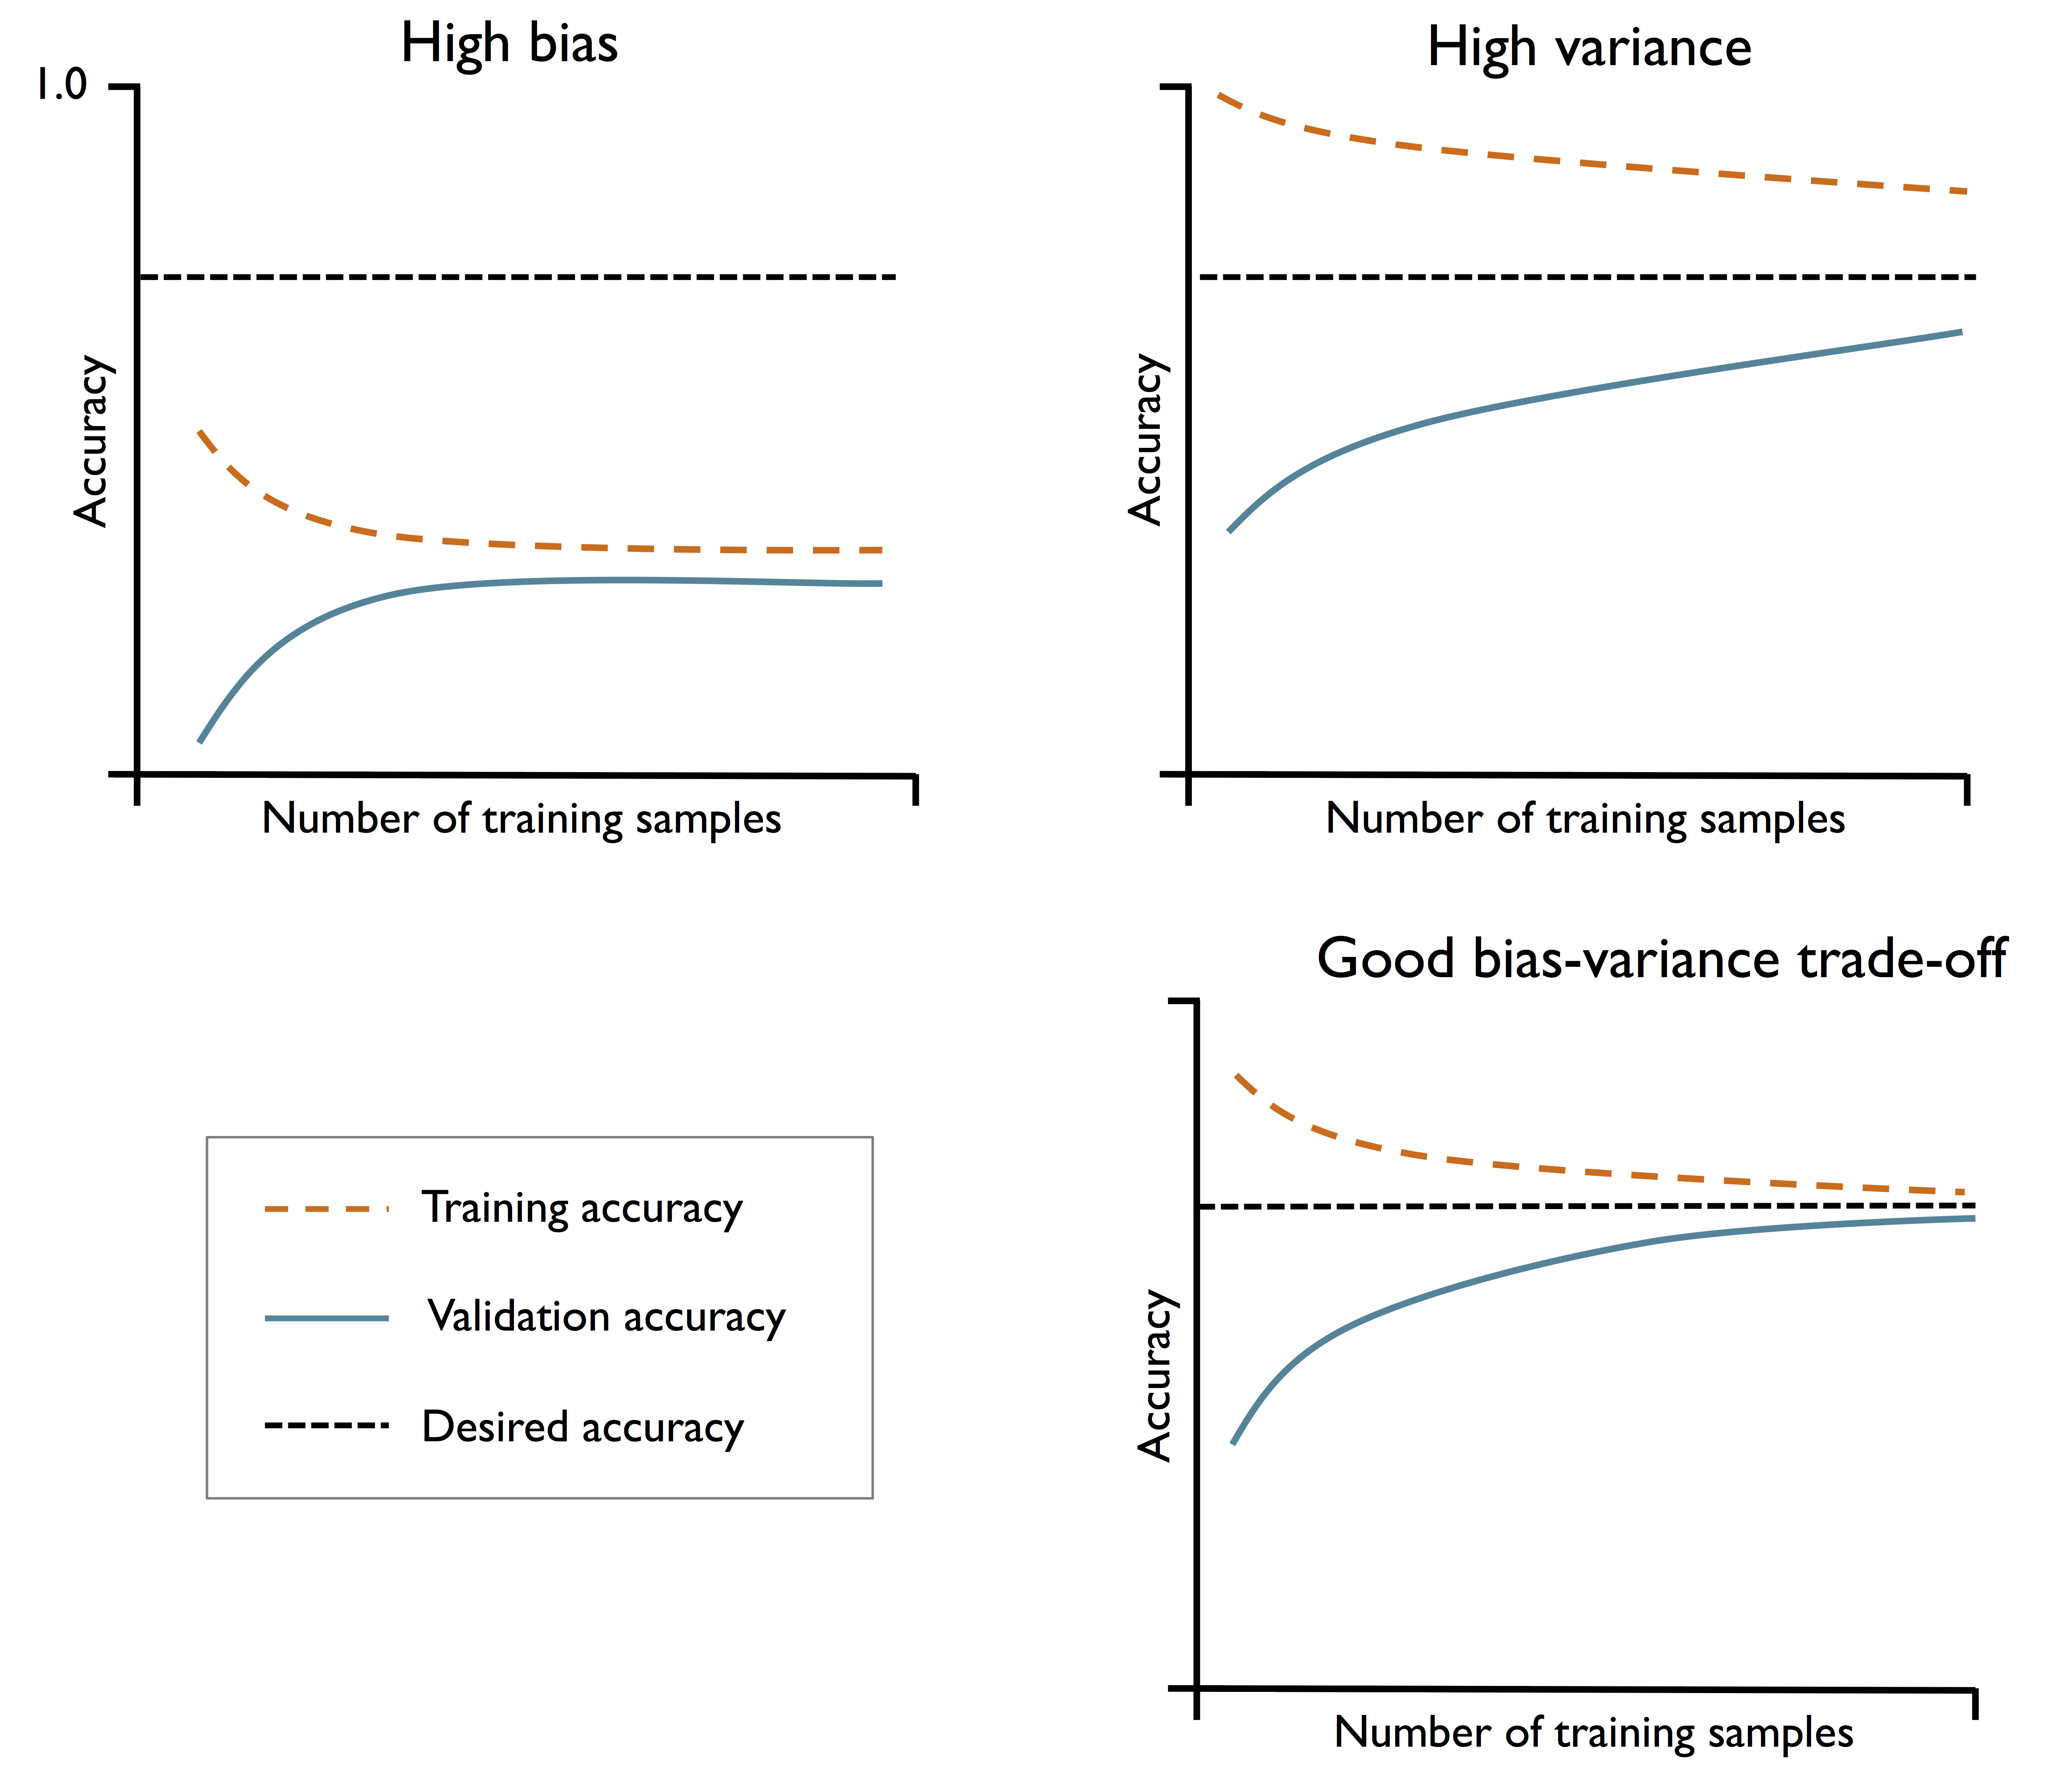

In [15]:
Image(filename='img/06_04.png', width=600)

[Image Source: Raschka](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb)

The diagram shows the learning curves of three hypothetical models. The learning curve is an illustration of the training and validation accuracy of a model, depending on the number of training data.

**High bias** occurs when the accuracy of the model is far from the desired accuracy (*underfitting*). Common strategies to avoid this are
* Selecting a more complex model (more parameters, degrees of freedom)
* Increasing the attributes, e.g. through [feature engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
* Reduction of regularization (if available)

**High variance** occurs when the gap between the training accuracy and the validation accuracy is very large. Common strategies to avoid this are
* Obtaining more data
* Increasing the regularization
* Reduction of attributes (e.g. through dimension reduction)
* Selection of a less complex model

In this case, it is unclear what the *desired accuracy* should be. This certainly needs to be checked on a case-by-case basis. In practice, one could test a model that is as complex and unregulated as possible in order to determine the "maximum training accuracy". This would at least allow an upper limit for the accuracy to be estimated.

In the following, we will look at the learning curves for our model (without PCA and with a larger `max_iter`):

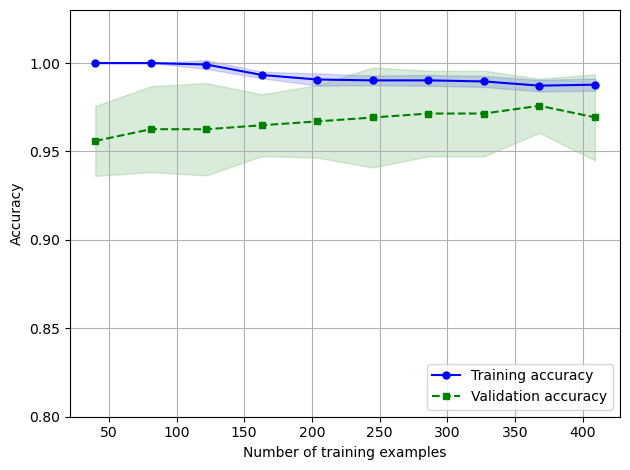

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
# plt.savefig('images/06_05.png', dpi=300)
plt.show()

`learning_curve` implements $k$-fold stratified cross-validation by default. Our model achieves good performance for an increasing amount of training data. However, we can also note that the training accuracy is high for small amounts of data and the gap between the training and validation accuracy increases for large amounts of data, which is an indicator for overfitting.

Alternatively, we can also look at **validation curves** to examine the influence of individual hyperparameters on the generalization ability of the model. Validation curves are very similar to learning curves, but visualize the accuracy values as a function of a model parameter. We can look at this below for the regularization parameter $C$ of the logistic regression:

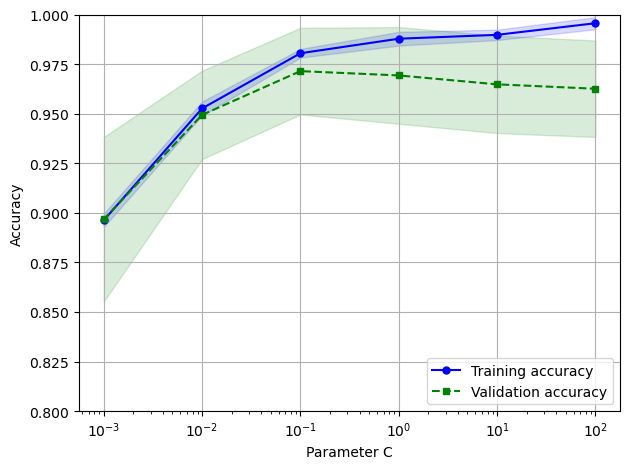

In [17]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()

This plot shows very clearly the bias-variance trade-off due to the regularization of a model. If the regularization is too large, the model accuracy suffers. However, if the regularization is too small, the model tends to overfit. A good mean value can be identified at $C = 10^{-1}$.

## Insert: Hyperparameter tuning and model selection
---

We have learned that the tripartite division of the data in holdout cross-validation (*Train, Valid, Test*) is mainly due to the **adaptation of the hyperparameters** of a model. Hyperparameters in the context of machine learning are those parameters that are set by the user (e.g. regularization $C$ in logistic regression) and are not optimized by the model during training (e.g. the weights of logistic regression).

To illustrate the combined process of evaluation and hyperparameter tuning here, we will look at a simple technique for optimizing hyperparameters: **Grid Search**. More details on hyperparameter tuning can be found in the corresponding lecture.

Grid Search is a **brute force approach** where a list of values for different hyperparameters is *exhaustively searched*. `GridSearchCV` from `scikit-learn` implements such a search, based on k-fold cross-validation:

In [18]:
from sklearn.model_selection import GridSearchCV

pipe_lr = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=1, solver='liblinear'))


param_grid = [{'logisticregression__C' : np.logspace(-3,3,7),
              'logisticregression__penalty' : ['l1', 'l2']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9780676328502416
{'logisticregression__C': 0.09999999999999999, 'logisticregression__penalty': 'l2'}


/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


For the best cross-validated classifier (`best_estimator_`), we can now determine the performance on the test data:

In [19]:
clf = gs.best_estimator_

# clf.fit(X_train, y_train) 
# the model must be trained again if refit=False (not necessary here)

print('Test-Accuracy: %.3f' % clf.score(X_test, y_test))

Test-Accuracy: 0.982


The k-fold cross-validation is suitable for obtaining an unbiased estimation of the performance of a model. However, if we want to choose between *different ML algorithms* (or *different hyperparameter configurations*), then a more complex approach to evaluation should be chosen: **nested cross-validation**. This approach is intended to avoid using the same parts of the data for model selection and performance evaluation (see also [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html), [here](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/) or [here](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-7-91)). However, there are also indications that nested cross-validation is not necessarily [necessary](https://arxiv.org/pdf/1809.09446.pdf) in practice.

In nested cross-validation, cross-validations are performed in two nested loops. The inner cross-validation loop is responsible for *model selection/hyperparameter tuning* and the outer cross-validation loop is used to estimate the *generalization error*. Here in the example with a **5x2 cross-validation**:

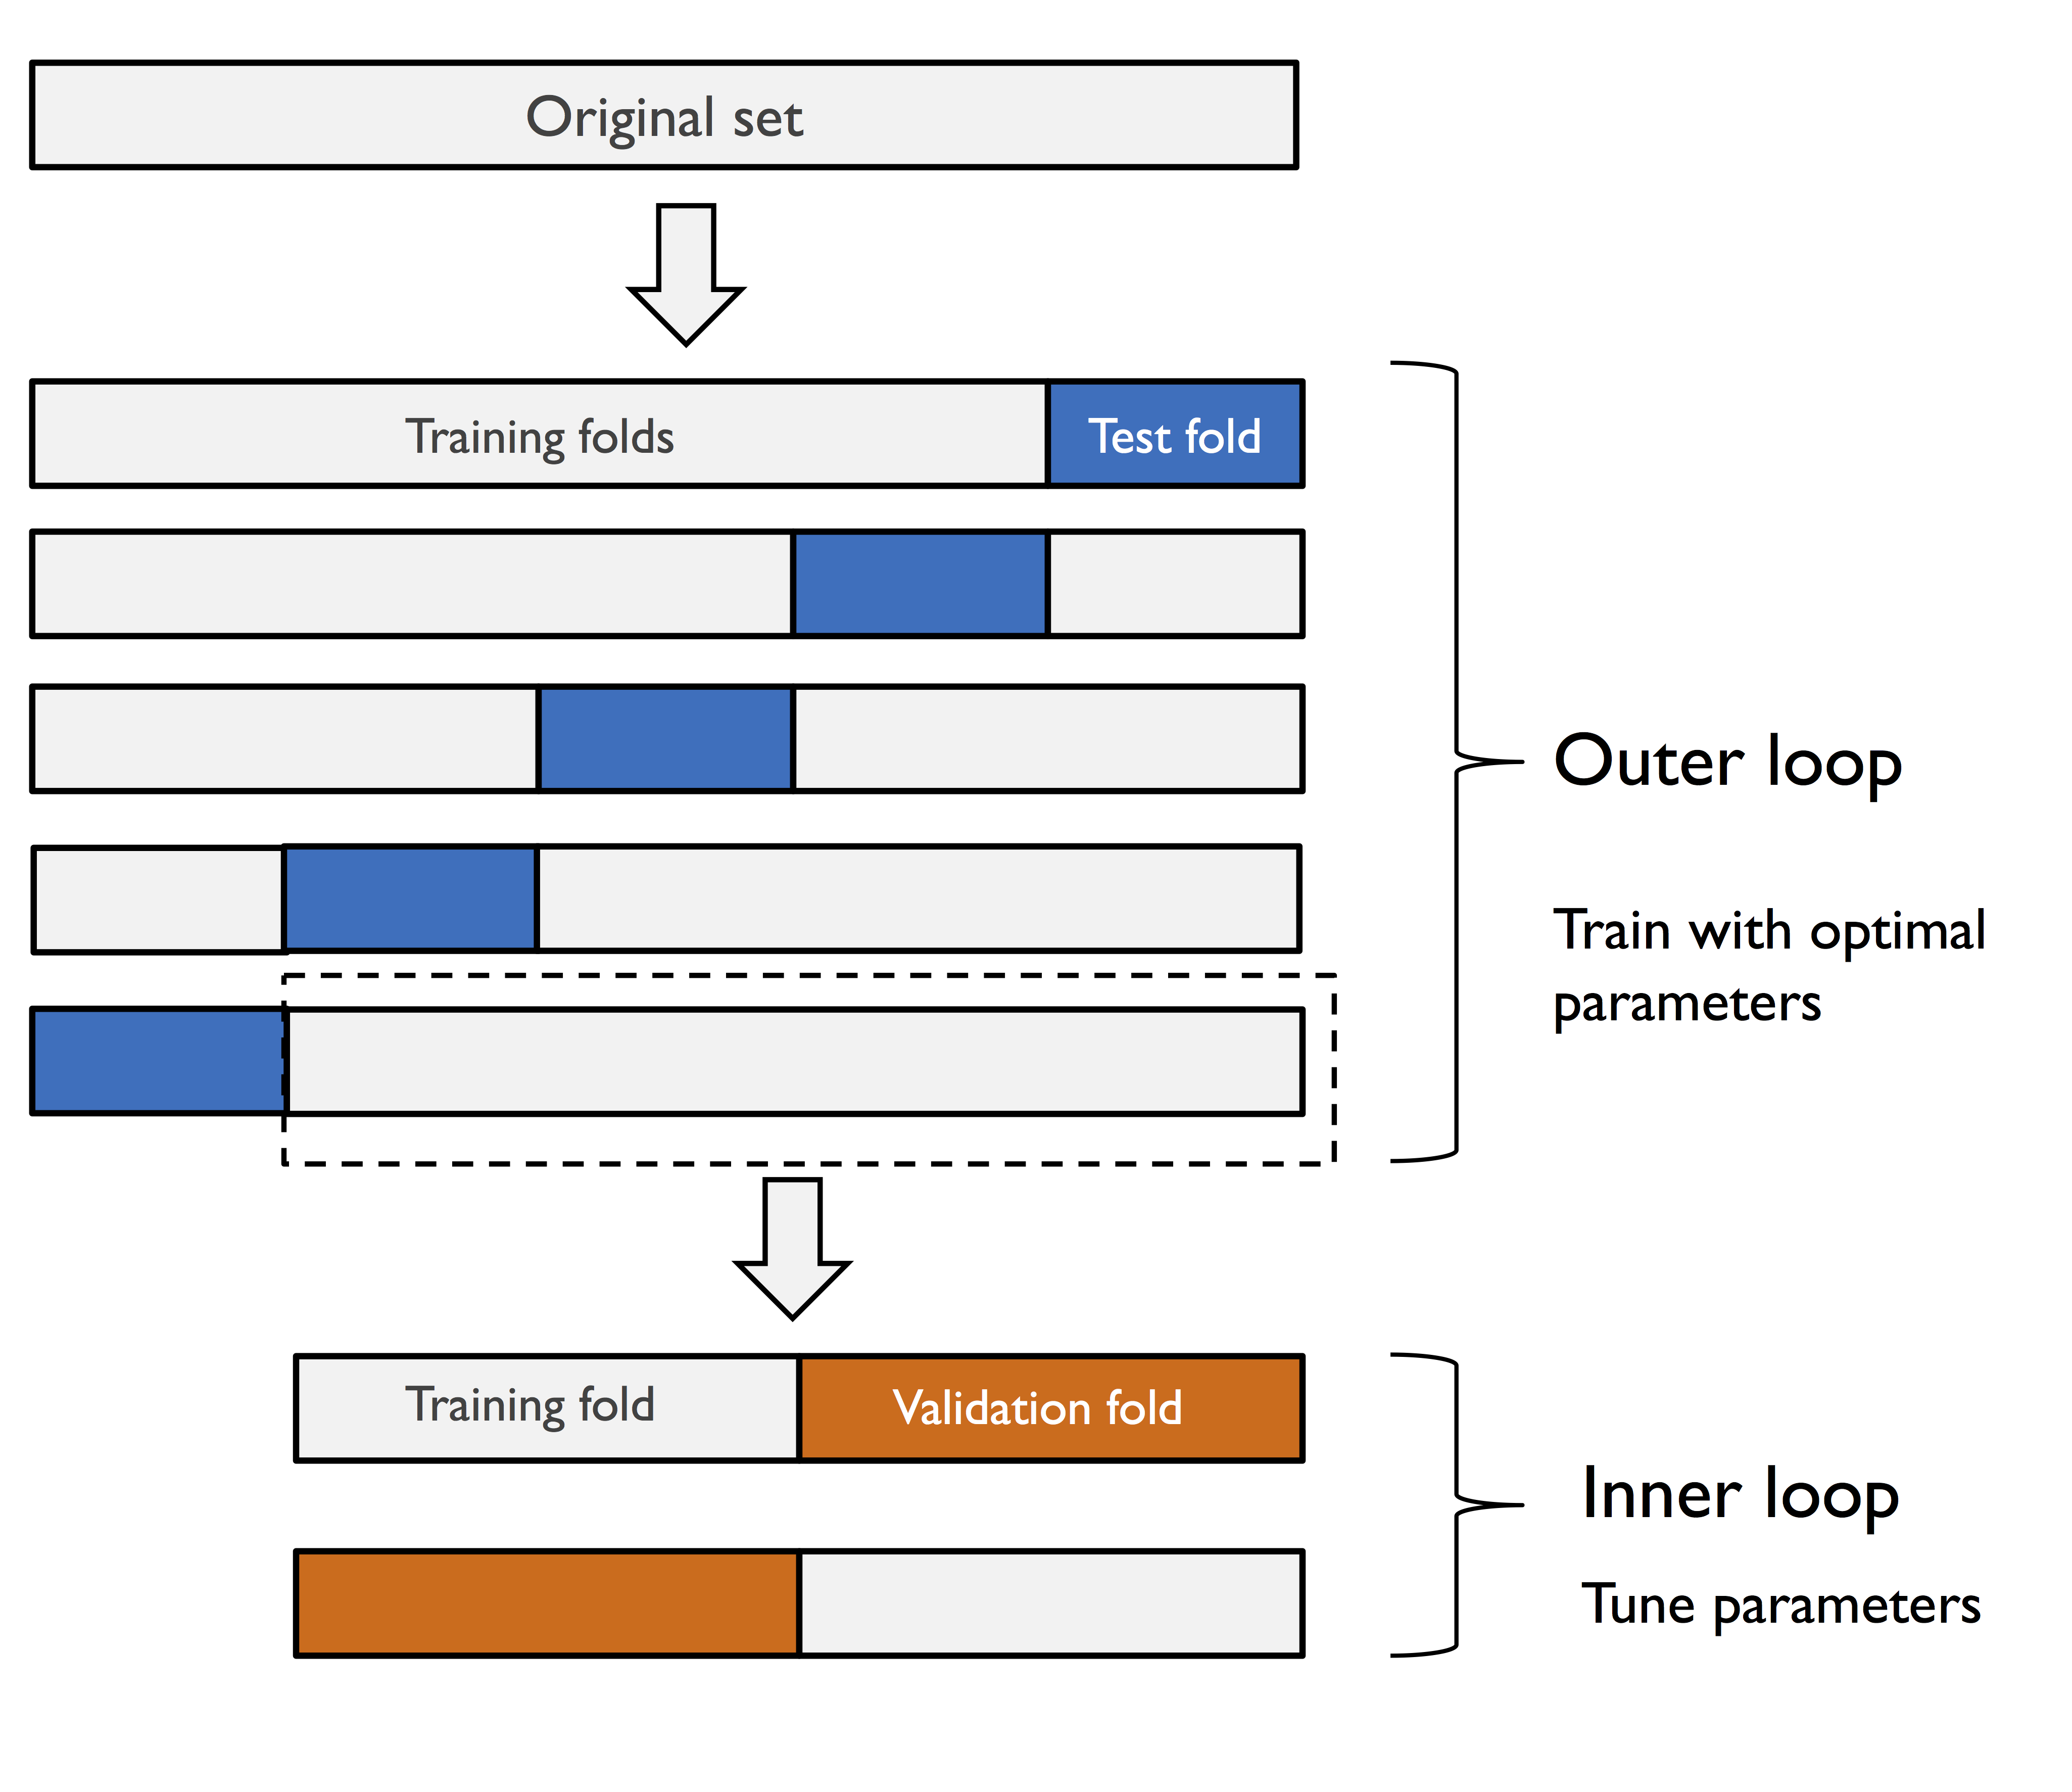

In [20]:
Image(filename='img/06_07.png', width=600)

[Image source: Raschka](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb)

With `scikit-learn` we can implement this as follows:

In [21]:
gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores),
                                      np.std(scores)))

CV Accuracy: 0.976 +/- 0.013


This accuracy is a good estimate of what we can expect when we apply our (hyperparameter-optimized) classifier to unknown data. At least, if the data corresponds to the same data space...

For comparison, we can test a decision tree here:

In [22]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv=2)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy', cv=5)
print('CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), 
                                      np.std(scores)))

CV Accuracy: 0.927 +/- 0.035


Logistic regression therefore seems to be the better model!

**Note:** Nested cross-validation only provides us with an unbiased estimator for the generalization ability of a hyperparameter-optimized model (rather: *a modeling process*) - but not the model itself! If we want to find the best hyperparameter configuration for a final model, we have to resort to simple cross-validation.

## Besides accuracy: important performance metrics and quality measures
---

In classification theory, we have already looked at some performance metrics, which we want to deepen and apply here.

### Confusion matrix

The confusion matrix is an important initial tool for estimating the quality of the model. We can see the number of the following cases at a glance:

* *true positive* ($\tau_{\text{pos}}$)
* *true negative* ($\tau_{\text{neg}}$)
* *false positive* ($\varphi_{\text{pos}}$)
* *false negative* ($\varphi_{\text{neg}}$)

In [23]:
from sklearn.metrics import confusion_matrix

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


This can be displayed more beautifully with the auxiliary function `ConfusionMatrixDisplay`:

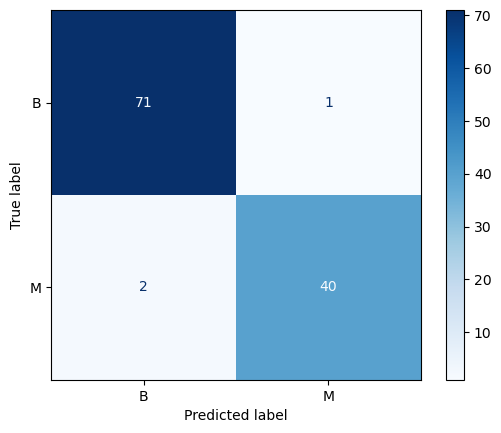

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=le.classes_, cmap='Blues')
plt.show()

Assuming that the presence of a malignant tumor ($\hat =$ M) represents the positive case (positive in the sense of "disease present"...), 40 positive cases were correctly classified (*true positive*). 71 negative cases ($\hat =$ B) were correctly classified as such (*true negative*). A total of 3 cases were misclassified. The two *false negative* cases are particularly serious here: malignant tumors were incorrectly identified as benign.

### Specificity and sensitivity

This use case makes it clear that accuracy is certainly not the only indicator of the quality of a classifier. In tumor classification, we particularly want to maximize the number of malignant tumors found. Secondarily, however, we also want to keep the number of benign tumors that are incorrectly classified as malignant low so as not to burden patients unnecessarily. We therefore want to optimize our model with regard to **specificity** $\tau_r$ and **sensitivity** ($\tau_{\text{pos},r}$):

* Specificity (*Precision*): $\tau_r=\tau_{\text{pos}}/(\tau_{\text{pos}}+\varphi_{\text{pos}})$
* Sensitivity (*Recall*): $\tau_{\text{pos},r}=\tau_{\text{pos}}/p$

If we optimize the sensitivity in our example, we minimize the probability of not identifying a malignant tumour. Conversely, however, we increase the number of tumors incorrectly classified as malignant (high number of *false positives*). If, on the other hand, we optimize the precision, we require a high degree of correctness in the classification of malignant tumors. However, this means that we may no longer identify malignant tumors as such (high number of *false negatives*).

We can also graphically represent the trade-off between specificity and sensitivity for our model using the test data as a **precision-recall curve**:

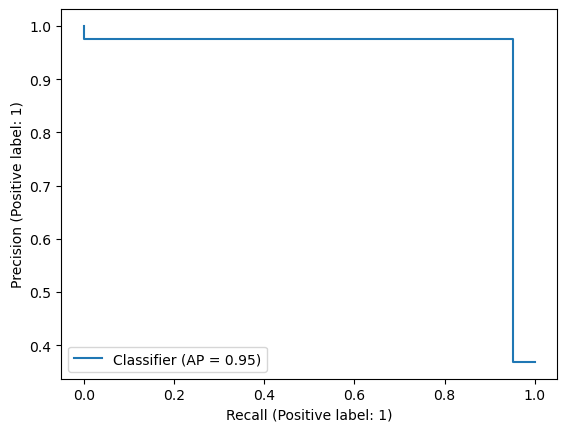

In [25]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(y_test,y_pred)
plt.show()

To balance the advantages and disadvantages of the two metrics, a combination in the form of the [F-measure](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators#F-Ma%C3%9F) is often evaluated:

$ F = 2 \times \frac{\text{relevance}\times\text{sensitivity}}{\text{relevance}+\text{sensitivity}} = 2 \times \frac{\tau_r \times \tau_{\text{pos},r}}{\tau_r + \tau_{\text{pos},r}} \in [0,1]$

An F-measure of $1$ corresponds to perfect relevance and sensitivity, an F-measure of $0$ occurs when either specificity or sensitivity is $0$. *Additional information:* The F-measure is almost always used as an indicator of model quality in scientific publications.

In `scikit-learn`, the metrics are contained in the `metrics` module:

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('relevance: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('sensitivity: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

relevance: 0.976
sensitivity: 0.952
F1: 0.964


All metrics from `scikit-learn` and explanations can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions).

In `scikit-learn` we can evaluate our model with our own metrics. To do this, we use the [`make_scorer` function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html), here in the example with `GridSearchCV`:

In [27]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

param_grid = [{'logisticregression__C' : np.logspace(-3,3,7),
              'logisticregression__penalty' : ['l1', 'l2']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring=scorer, 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9829129082019504
{'logisticregression__C': 0.09999999999999999, 'logisticregression__penalty': 'l2'}


/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dschaudt/miniconda3/envs/aicoss12/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In this case, the parameter configuration with the highest accuracy also leads to the highest F-score. Compared to the test data, we slightly overestimate the F-score.

The `classification_report` provides a clear presentation of some metrics:

In [28]:
from sklearn.metrics import classification_report

pipe_lr = make_pipeline(StandardScaler(),
                         LogisticRegression(random_state=1, solver='liblinear'))

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

print(classification_report(y_true = y_test, y_pred = y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           B       0.97      0.99      0.98        72
           M       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### ROC curve

By adjusting the decision threshold of the model, the *relationship between recall and false-positive rate* can be manipulated directly. Example: we classify a malignant tumor as malignant from a prediction probability of >40% (previously: >50%). Although this will increase recall, as we will identify more malignant tumors, it will also increase the false-positive rate. This relation can be measured directly using the [ROC curves](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (**Receiver Operating Characteristic**).

In the following code example, only 2 attributes of the data set are used. This increases the complexity of the task and makes the ROC curve more visually appealing.

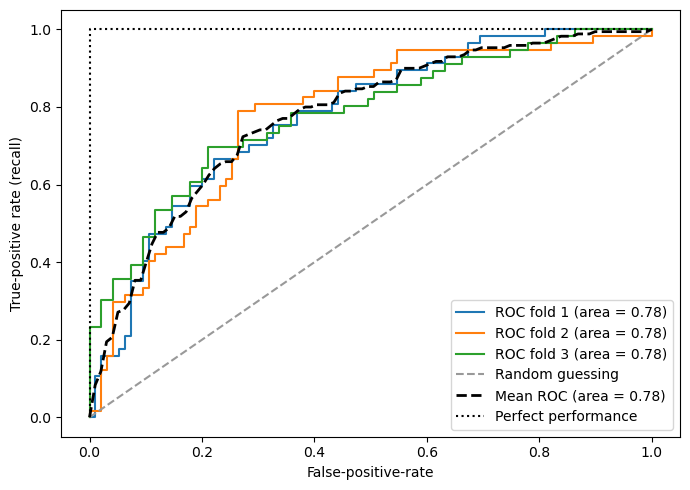

In [29]:
from sklearn.metrics import roc_curve, auc
from numpy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False-positive-rate')
plt.ylabel('True-positive rate (recall)')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('images/06_10.png', dpi=300)
plt.show()

A ROC curve close to the diagonal can be interpreted as the expected outcome of a random process. A perfect model would be placed in the upper left corner, with a sensitivity of $1$ and a false positive rate of $0$. Based on the ROC curve, an additional single metric can be calculated: **ROC-AUC** (or often simply **AUC**). This indicates the area under the ROC curve (in the plot as *area*). An AUC of $1$ represents a perfect model. The diagonal has an area of $0.5$. For values smaller than $0.5$, it can be assumed that the cases "positive" and "negative" have been swapped.

**Note:** ROC curves are more susceptible to data with uneven class distribution (see e.g. [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/) and [here](http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf)). In particularly severe cases, the precision-recall curve is therefore preferable as an analysis tool.

# Learning outcomes
---

The most important learning objectives of this unit at a glance:

* Through `pipelines` we can easily transfer entire ML processes (data preparation & modeling) to a different data context.
* The generalization ability of a ML model can be measured with the holdout method and cross-validation.
* The bias-variance problem can be identified with learning curves and validation curves.
* Using `GridSearchCV` we can find suitable hyperparameters for our model. Nested cross-validation provides an unbiased estimate of the generalization error.
* Apart from accuracy, there are other important quality measures (depending on the application), such as sensitivity and relevance. The robustness of a model with regard to its decision threshholds can be determined using the ROC curve and the ROC-AUC.